## Import imports

In [3]:
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from knn import KNNClassifier, BatchedKNNClassifier
from knn.model_selection import knn_cross_val_score

In [4]:
np.random.seed(42)

## Download dataset

In [9]:
# data = fetch_openml("mnist_784")

# with open('mnist.pkl', 'wb') as file:
#     pickle.dump(data, file)

In [8]:
with open('mnist.pkl', 'rb') as file:
    data = pickle.load(file)

In [10]:
print(data.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [11]:
X, y = data['data'], data['target'].astype('int')

### Split dataset 

In [12]:
train_idx = 60000

In [13]:
X_train, y_train = X[:train_idx], y[:train_idx]

In [14]:
X_test, y_test = X[train_idx:], y[train_idx:]

In [15]:
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

### Choose features 

In [16]:
feature_sizes = [10, 20, 100]

In [17]:
features = {}

In [18]:
size_arr = np.arange(X_train.shape[1])

In [19]:
for f_size in feature_sizes:
    features[f_size] = np.random.choice(size_arr, size=f_size, replace=False)

### Test algorithms (time)

In [20]:
alg_list = ['brute', 'ball_tree', 'kd_tree', 'my_own']
n_nbs = 5
metr = 'euclidean'

In [21]:
all_times = defaultdict(dict) 

In [ ]:
for algo in alg_list:
    for f_size in feature_sizes:
        print('Algorithm {}. Number of features {}'.format(algo, f_size))
        time_start = time.time()
        clf = BatchedKNNClassifier(algorithm=algo, n_neighbors=n_nbs, metric=metr)
        clf.set_batch_size(2500)
        clf.fit(X_train[:, features[f_size]], y_train)
        clf.predict(X_test[:, features[f_size]])
        all_times[algo][f_size] = time.time() - time_start

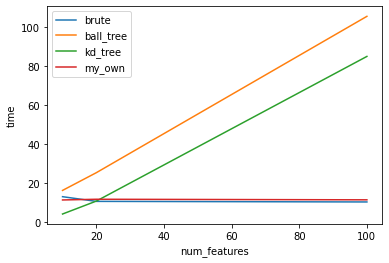

In [57]:
for algo in alg_list:
    plt.plot(list(all_times[algo].keys()), list(all_times[algo].values()), label=algo)
    plt.xlabel('num_features')
    plt.ylabel('time')
plt.legend();

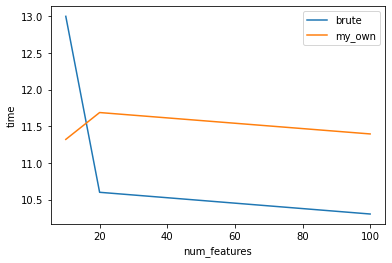

In [58]:
for algo in ['brute', 'my_own']:
    plt.plot(list(all_times[algo].keys()), list(all_times[algo].values()), label=algo)
    plt.xlabel('num_features')
    plt.ylabel('time')
plt.legend()

### Cross validation! 

In [28]:
cross_val = KFold(n_splits=3)

In [32]:
cv_scores = defaultdict(dict)
cv_times = defaultdict(dict)

In [30]:
m_list = ['euclidean', 'cosine']

In [23]:
for algo in alg_list:
    for metr in m_list:
        if algo in ['ball_tree', 'kd_tree']:
            if metr == 'cosine':
                continue
        print('Algorithm {}. Distance {}'.format(algo, metr))
        time_start = time.time()
        kwargs = {'algorithm': algo, 'metric': metr}
        cv_scores[algo][metr] = knn_cross_val_score(
            X[:, features[10]], y, np.arange(10)+1, cv=cv, scoring="accuracy",
            b_size=2500, **kwargs
        )
        cv_times[algo][metr] = time.time() - time_start

In [48]:
for algo in alg_list:
    print(algo, np.array(cv_scores[algo]['euclidean'][1]).mean())

brute 0.3782713793387733
ball_tree 0.37444292341719315
kd_tree 0.3790571777052398
my_own 0.37735710505252257


In [49]:
for algo in alg_list:
    print(algo, np.array(cv_scores[algo]['euclidean'][10]).mean())

brute 0.46679998672133255
ball_tree 0.4657570963132189
kd_tree 0.46564280284389525
my_own 0.46679998672133255


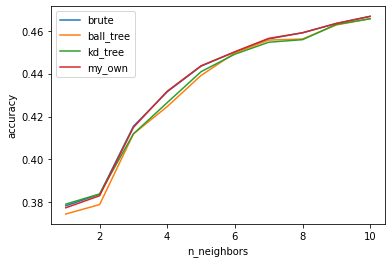

In [55]:
for algo in alg_list:
    idx = list(range(1, 11))
    values = [np.array(cv_scores[algo]['euclidean'][i]).mean() for i in idx]
    plt.plot(idx, values, label=algo)
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.legend();

In [59]:
{algo: cv_times[algo]['euclidean'] for algo in alg_list}

{'brute': 59.935078382492065,
 'ball_tree': 57.53069519996643,
 'kd_tree': 10.477044105529785,
 'my_own': 63.36557722091675}

### Weighted cross-validation! 

In [24]:
for algo in alg_list:
    for metr in m_list:
        if algo in ['ball_tree', 'kd_tree']:
            if metr == 'cosine':
                continue
        print('Algorithm {}. Distance {}'.format(algo, metr))
        time_start = time.time()
        kwargs = {'algorithm': algo, 'metric': metr, 'weights': 'distance'}
        cv_scores[algo][metr] = knn_cross_val_score(
            X[:, features[10]], y, np.arange(10)+1, cv=cv, scoring="accuracy",
            b_size=2500, **kwargs
        )
        cv_times[algo][metr] = time.time() - time_start

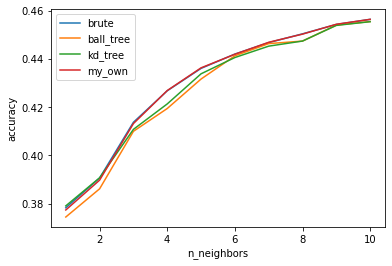

In [61]:
for algo in alg_list:
    idx = list(range(1, 11))
    values = [np.array(cv_scores[algo]['euclidean'][i]).mean() for i in idx]
    plt.plot(idx, values, label=algo)
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.legend();

### Best algorithm testing: 

In [62]:
knn = BatchedKNNClassifier(n_neighbors=10, algorithm='my_own', metric='euclidean', weights='uniform')

In [64]:
knn.set_batch_size(1000)

In [65]:
knn.fit(X_train, y_train)

In [66]:
y_pred = knn.predict(X_test)

100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


In [67]:
accuracy_score(y_test, y_pred)

0.9665

In [69]:
kwargs = {'algorithm': 'my_own', 'metric': 'euclidean', 'weights': 'distance'}
cv_scores_best = knn_cross_val_score(
    X, y, np.arange(10)+1, cv=cv, scoring="accuracy",
    b_size=2500, **kwargs
)

100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


In [73]:
cv_means = {n_nbr: np.array(cv_scores_best[n_nbr]).mean() for n_nbr in cv_scores_best.keys()}

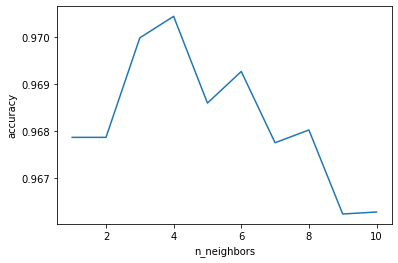

In [78]:
plt.plot(list(cv_means.keys()), list(cv_means.values()))
plt.xlabel('n_neighbors')
plt.ylabel('accuracy');